In [ ]:
# Importing modules
import pandas as pd
# Read data into papers
papers = pd.read_csv('final.csv')
# Print head
papers.head()

,Unnamed: 0,title,description,recentChanges,Updated Date
0,0,Eye Filter (Blue light filter),"This app draws a translucent mask over screen,...",Minor improvement.\r\nAllow remove ads by IAP.,24-Jul-20
1,1,Drizly: Fast alcohol delivery,Get the door. It's the liquor store.™\r\n\r\nL...,Fixes bug with facebook login and creating a n...,06-Sep-22
2,2,Card Maker for PKM,PKM Card Maker is where you can make your own ...,- 🛠 Improvement and bug fix !!,23-Aug-22
3,3,Progression - Workout Tracker,"Workout tracking, made simple and beautiful\r\...",NaN,02-Jun-22
4,4,My Finances,My Finances is a perfect tool for expense cont...,Fix for fullscreen Ads,02-Jun-22


In [ ]:
# Load the regular expression library
import re
# Remove punctuation
papers['recentChanges']=papers['recentChanges'].apply(str)
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[www]', '', x))
papers['paper_text_processed'] = papers['recentChanges'].map(lambda x: re.sub('[com]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

0              minr iprveent.\r\nallw reve ads by iap.
1    fixes bug with faebk lgin and reating a new dr...
2                         - 🛠 iprveent and bug fix !! 
3                                                  nan
4                                 fix fr fullsreen ads
Name: paper_text_processed, dtype: object

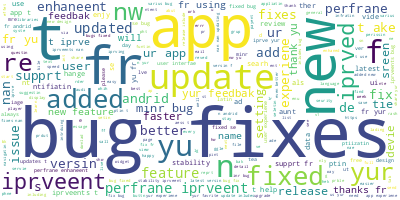

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['minr', 'iprveent', 'allw', 'reve', 'ads', 'iap']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.042*"nan" + 0.035*"fixes" + 0.033*"bug" + 0.028*"fr" + 0.019*"iprveents" '
  '+ 0.014*"perfrane" + 0.011*"yu" + 0.010*"versin" + 0.010*"app" + '
  '0.009*"new"'),
 (1,
  '0.041*"fixed" + 0.028*"fr" + 0.014*"andrid" + 0.013*"yu" + 0.013*"user" + '
  '0.012*"supprt" + 0.012*"issue" + 0.011*"versin" + 0.009*"se" + '
  '0.009*"better"'),
 (2,
  '0.034*"fr" + 0.020*"yu" + 0.014*"yur" + 0.013*"andrid" + 0.013*"new" + '
  '0.012*"bug" + 0.011*"nw" + 0.010*"added" + 0.010*"nan" + 0.009*"fixes"'),
 (3,
  '0.028*"yu" + 0.020*"fr" + 0.019*"added" + 0.016*"app" + 0.014*"new" + '
  '0.014*"fix" + 0.013*"yur" + 0.012*"bugs" + 0.010*"bug" + 0.009*"fixed"'),
 (4,
  '0.033*"new" + 0.021*"yur" + 0.020*"fr" + 0.018*"yu" + 0.014*"app" + '
  '0.011*"nw" + 0.011*"fixes" + 0.011*"se" + 0.010*"iprveents" + '
  '0.010*"added"'),
 (5,
  '0.023*"fixes" + 0.021*"added" + 0.018*"bug" + 0.013*"fixed" + '
  '0.013*"iprved" + 0.012*"bugs" + 0.011*"dengan" + 0.009*"bca" + '
  '0.008*"perfrane" + 0.006*"seuri

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5443443067730707


**Finding Optimal Number of Topics for highest coherence value**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)

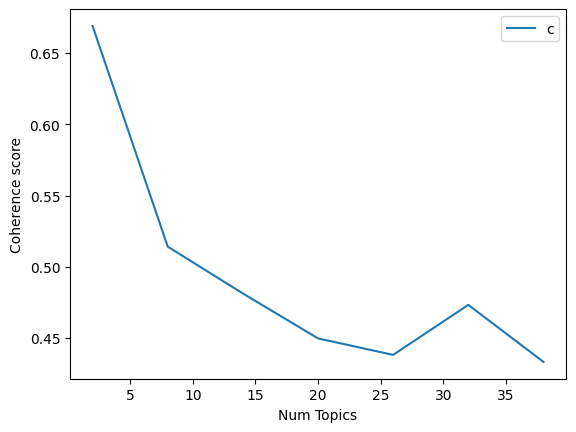

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6691
Num Topics = 8  has Coherence Value of 0.5142
Num Topics = 14  has Coherence Value of 0.4813
Num Topics = 20  has Coherence Value of 0.4498
Num Topics = 26  has Coherence Value of 0.4382
Num Topics = 32  has Coherence Value of 0.4733
Num Topics = 38  has Coherence Value of 0.4333


In [ ]:
#Finding index of max coherence value then using it to get optimal num_topics
index= coherence_values.index(max(coherence_values))
num_topics= x[index]
print(num_topics)

2


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           )

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6690555292396396


In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 

**Intertopic Distance (Visualisation)**

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.163162  0.0       1        1  61.46525
0     -0.163162  0.0       2        1  38.53475, topic_info=          Term        Freq       Total Category  logprob  loglift
11       fixes  683.000000  683.000000  Default  30.0000  30.0000
160         yu  614.000000  614.000000  Default  29.0000  29.0000
141      fixed  303.000000  303.000000  Default  28.0000  28.0000
63       added  248.000000  248.000000  Default  27.0000  27.0000
83   iprveents  450.000000  450.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
156     issues   36.436316   64.303064   Topic2  -5.8159   0.3856
55          nw   52.726298  211.600834   Topic2  -5.4463  -0.4360
30         app   57.551100  529.415500   Topic2  -5.3588  -1.2655
465         ui   34.701046   70.807520   Topic2  -5.8647   0.2404
7          bug   53.259647  665.637454   Topic2  -5.4363  -1.5720

[124 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
189       1  0.117272     add
189       2  0.891267     add
63        1  0.004030   added
63        2  0.995503   added
74        1  0.988851     ade
...     ...       ...     ...
93        1  0.626790  versin
93        2  0.372350  versin
160       1  0.998701      yu
160       2  0.001627      yu
161       1  0.998566     yur

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    rows = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                rows.append([int(topic_num), round(prop_topic, 4), topic_keywords, texts[i]])
            else:
                break

    # Convert the list of rows to a DataFrame
    sent_topics_df = pd.DataFrame(rows, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text'])

    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.insert(1, "App_name", papers['title'])
del df_dominant_topic['Document_No']
# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,App_name,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Eye Filter (Blue light filter),0,0.7069,"fixed, added, fr, nan, iprved, andrid, de, fix...",minr iprveent.\r\nallw reve ads by iap.
1,Drizly: Fast alcohol delivery,1,0.7351,"fixes, yu, bug, fr, app, iprveents, yur, new, ...",fixes bug with faebk lgin and reating a new dr...
2,Card Maker for PKM,1,0.5780,"fixes, yu, bug, fr, app, iprveents, yur, new, ...",- 🛠 iprveent and bug fix !!
3,Progression - Workout Tracker,0,0.7500,"fixed, added, fr, nan, iprved, andrid, de, fix...",nan
4,My Finances,0,0.8790,"fixed, added, fr, nan, iprved, andrid, de, fix...",fix fr fullsreen ads
5,0-200 Situps Abs Trainer,1,0.9297,"fixes, yu, bug, fr, app, iprveents, yur, new, ...","suer is in full effet, let's get that beah bdy!"
6,WDSU Parade Tracker,1,0.9375,"fixes, yu, bug, fr, app, iprveents, yur, new, ...",as parades begin t return t new orleans the wd...
7,Animal Planet GO,1,0.9446,"fixes, yu, bug, fr, app, iprveents, yur, new, ...",• nw streaing ntent fr up t 14 netwrks fr the ...
8,Fuelmeter: Fuel consumption,0,0.7500,"fixed, added, fr, nan, iprved, andrid, de, fix...",nan
9,Wishbone - Compare Anything,1,0.8300,"fixes, yu, bug, fr, app, iprveents, yur, new, ...",bug fixes


In [ ]:
from google.colab import files
df_dominant_topic.to_csv('Recent_Changes_analysis.csv', encoding = 'utf-8-sig')
files.download('Recent_Changes_analysis.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>